outliers.shape (830,)
outlier fraction 0.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Columns: 155 entries, 0 to 154
dtypes: float64(155)
memory usage: 2.0 MB
None
nu 0.5
The best parameters are {'C': 0.01, 'gamma': 0.10000000000000001} with a score of 1.00
(1660, 155)
(1660,)
[ 1.          1.          0.78787879  0.66666667  0.75757576]
[ 1.          1.          0.78787879  0.81818182  0.21212121]
[ 1.          1.          0.87878788  0.63636364  0.51515152]
[ 1.          1.          0.60606061  0.93939394  0.87878788]
[ 1.          1.          0.72727273  0.72727273  0.45454545]
[ 1.          1.          0.72727273  0.54545455  0.48484848]
[ 1.          1.          0.75757576  0.42424242  0.48484848]
[ 1.          1.          0.81818182  0.42424242  0.72727273]
[ 1.          1.          0.75757576  0.87878788  0.81818182]
[ 1.          1.          0.63636364  0.75757576  0.78787879]
0.836363636364
[ 1.          1.          0.71212121  0.25757576  0.2878

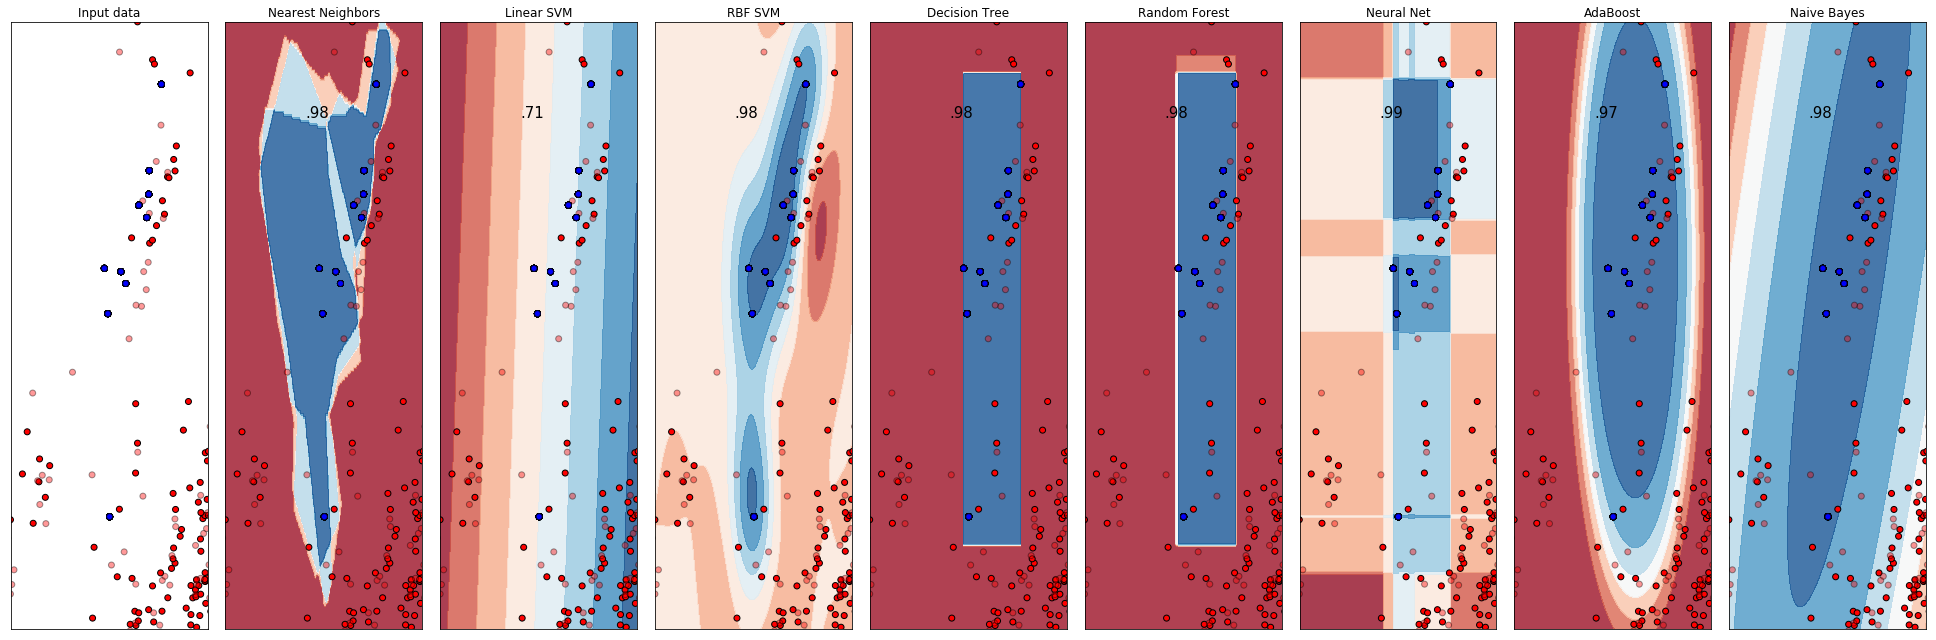

In [10]:
%matplotlib inline

import lsanomaly
import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('C:/Users/user/.spyder-py3/features.csv', low_memory=False)

data.loc[data['UUID'] == "NSKPJ1502989685690", "attack"] = 1  
data.loc[data['UUID'] != "NSKPJ1502989685690", "attack"] = -1
df_majority = data[data['attack']==-1]
df_minority = data[data['attack']==1]
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=830,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])

#print(data['attack'].value_counts())

target = data['attack']

data.drop(["UUID", "attack"], axis=1, inplace=True)
#data=data.loc[:, 'Touch_Pressure':]

#data.drop(["HR_Timestamp","Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Date_Time","Country_Code","Location","Num_of_CPU_Cores","Location_lat","Location_long"], axis=1, inplace=True)

categorical_columns=["Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"]
cate_data = data[categorical_columns]

#for col in data.columns.values:
#    print(col, data[col].unique())

pd.set_option('mode.chained_assignment', None)

def label_encode(cate_data, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(cate_data[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(cate_data[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        cate_data[col] = col_values_transformed
 
to_be_encoded_cols = cate_data.columns.values
label_encode(cate_data, to_be_encoded_cols)
#display(cate_data.head())

data.drop(["Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"], axis=1, inplace=True)
data=pd.concat([data,cate_data], axis=1)
#display(data.head())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data= pd.DataFrame(scaled_data)
#display(scaled_data.head())

outliers = target[target == -1]  

print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

# check the shape for sanity checking.
scaled_data.shape
print(scaled_data.info())

from sklearn.model_selection import train_test_split  
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = outliers.shape[0] / target.shape[0]  
print("nu", nu)
from sklearn.cross_validation import KFold, cross_val_score
#k_fold = KFold(len(target), n_folds=5, shuffle=True, random_state=0)
#model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.50)
#scores=cross_val_score(model, scaled_data, target, cv=k_fold,scoring='accuracy')
#print(scores.mean())
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cval = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cval)
grid.fit(scaled_data, target)
print("The best parameters are %s with a score of %0.2f"% (grid.best_params_, grid.best_score_))

from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(target,n_folds=5)
print(scaled_data.shape)
print(target.shape)
for train, test in skf:
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model1 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model1.fit(X_train, Y_train)
    scores = cross_val_score(model1,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())

from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=36851234)
for train, test in rskf.split(scaled_data,target):
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model2 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model2.fit(X_train, Y_train)
    scores = cross_val_score(model2,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())
#print(Y_train.value_counts())
#print(y_test.value_counts())
train_data, test_data, train_target, test_target = train_test_split(scaled_data, target, test_size = 0.2)  
train_data.shape

#from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = outliers.shape[0] / target.shape[0]  
print("nu", nu)

#model=RandomForestClassifier()
#model.fit(train_data,train_target) 

model3 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
model3.fit(train_data) 

from sklearn import metrics  
preds = model3.predict(train_data)  
targs = train_target


print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

preds = model.predict(test_data)  
targs = test_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
reduced_data= ipca.fit_transform(scaled_data)


XYdata=(reduced_data,target)
datasets=[XYdata]
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    #X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(reduced_data, target, test_size=.4, random_state=42)

    X=np.array(scaled_data)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #print(len(datasets), len(classifiers))
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,edgecolors='k')
        # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.4,edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i+=1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        score = clf.score(X_test, y_test)
        print("The classifier ",name," has accuracy of ",score)
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            #Z = clf.decision_function(X_test)
        #else:
            #Z = clf.predict_proba(X_test)
        #print(X_test.shape)
            # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,edgecolors='k', alpha=0.4)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(.4, .4, ('%.2f' % score).lstrip('0'),size=15, horizontalalignment='right')
        i+=1
plt.tight_layout()
plt.show()

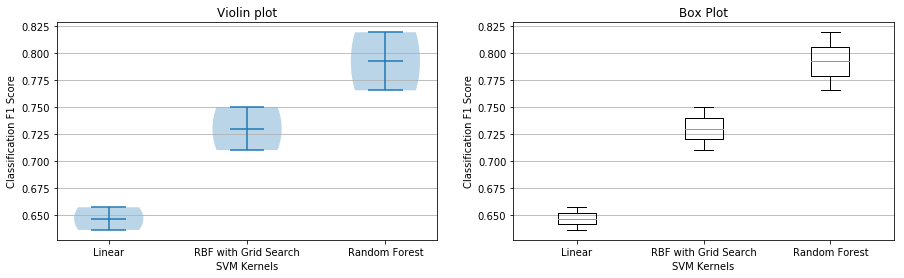

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# generate some random test data
all_data = np.array([[0.63614, 0.71011,0.765576338380234],[0.65714,0.7501,0.819380234]])


# plot violin plot
axes[0].violinplot(all_data,
                   showmeans=False,
                   showmedians=True)
axes[0].set_title('Violin plot')

# plot box plot
axes[1].boxplot(all_data)
axes[1].set_title('Box Plot')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('SVM Kernels')
    ax.set_ylabel('Classification F1 Score')

# add x-tick labels
plt.setp(axes, xticks=([y+1 for y in range(len(all_data)+1)]),
         xticklabels=['Linear', 'RBF with Grid Search','Random Forest'])
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


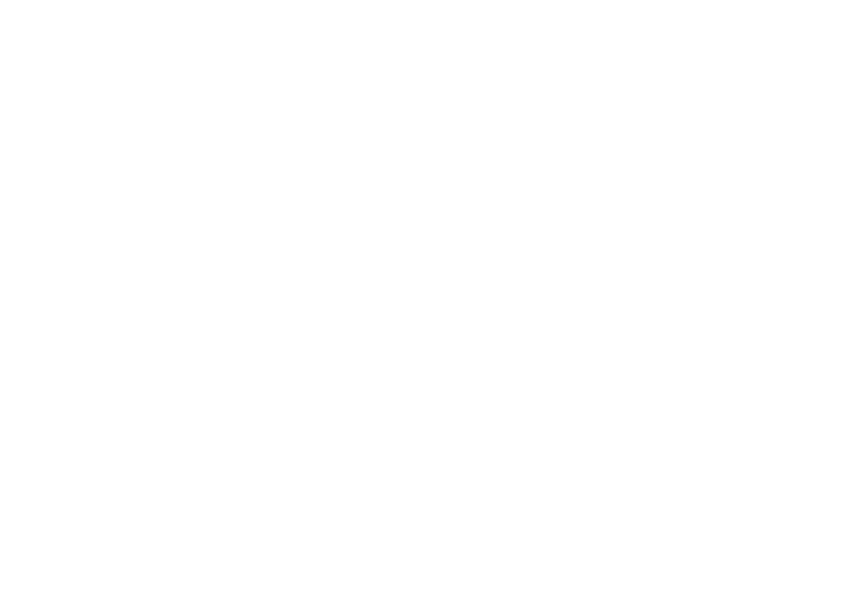

In [2]:
import sys
sys.path.append('C:/Users/S/.spyder-py3')
from mlrefined_libraries import superlearn_library as superlearn
datapath = '../../mlrefined_datasets/superlearn_datasets/'
classif_plotter = superlearn.multi_lin_classification_demo

# standard imports
import matplotlib.pyplot as plt

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2
data3 = np.loadtxt('C:/Users/S/Documents/PY/selectedsh.csv',delimiter = ',')

# create an instance of the ova demo
demo3 = superlearn.ova_illustrator.Visualizer(data3)

# visualize dataset
demo3.show_dataset()

,UUID,Language,Hardware_Model,SDK_Version,Manufacture,Screen_Size,Time_Zone,Country_Code
0,48,0,40,3,18,23,7,1
1,48,0,40,3,18,23,7,1
2,48,0,40,3,18,23,7,1
3,48,0,40,3,18,23,7,1
4,48,0,40,3,18,23,7,1


,Num_of_CPU_Cores,pLN1,p.2,pLN3,pt4,pi5,pe6,pLN7,p58,pLN9,...,avdu2,avgp,avga,Language,Hardware_Model,SDK_Version,Manufacture,Screen_Size,Time_Zone,Country_Code
0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,88.200000,1.0,0.004412,0,40,3,18,23,7,1
1,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,95.400000,1.0,0.004167,0,40,3,18,23,7,1
2,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,575.333333,1.0,0.008333,0,40,3,18,23,7,1
3,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,466.400000,1.0,0.008211,0,40,3,18,23,7,1
4,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,121.800000,1.0,0.009804,0,40,3,18,23,7,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Columns: 155 entries, Num_of_CPU_Cores to Country_Code
dtypes: float64(148), int64(7)
memory usage: 932.5 KB
initial data info None
data is (770, 155)
(770, 155)
(770,)
155
metrics


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


metrics
metrics
metrics
metrics
loop  3
f1  0.5667536215588165
Accuracy: 0.6090909090909091
metrics
metrics
metrics
metrics
metrics
loop  4
f1  0.6614617417214819
Accuracy: 0.6935064935064934
metrics
metrics
metrics
metrics
metrics
loop  5
f1  0.7774829931972789
Accuracy: 0.7974025974025973
metrics
metrics
metrics
metrics
metrics
loop  6
f1  0.789604205318491
Accuracy: 0.8077922077922077
metrics
metrics
metrics
metrics
metrics
loop  7
f1  0.7965429808286951
Accuracy: 0.8116883116883116
metrics
metrics
metrics
metrics
metrics
loop  8
f1  0.8294867037724181
Accuracy: 0.8415584415584416
metrics
metrics
metrics
metrics
metrics
loop  9
f1  0.8838218923933209
Accuracy: 0.8935064935064935
metrics
metrics
metrics
metrics
metrics
loop  10
f1  0.889969078540507
Accuracy: 0.8987012987012989
metrics
metrics
metrics
metrics
metrics
loop  11
f1  0.8848484848484848
Accuracy: 0.8935064935064935
metrics
metrics
metrics
metrics
metrics
loop  12
f1  0.9114285714285714
Accuracy: 0.9181818181818182
metrics

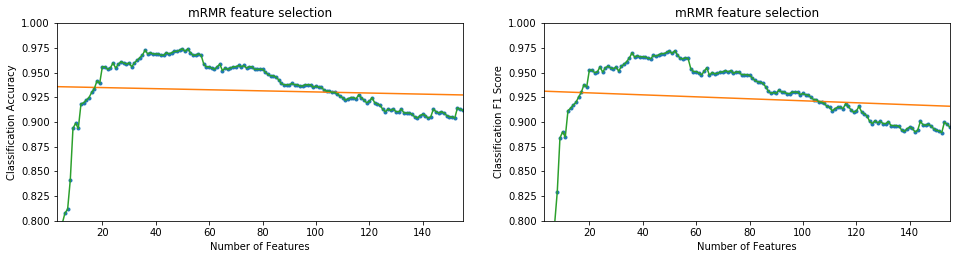

here


In [36]:
%matplotlib inline

import lsanomaly
import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA


# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('C:/Users/user/.spyder-py3/features1.csv', low_memory=False)
'''data.loc[data['UUID'] == "RVTNB1502866560357", "attack"] = 1  
data.loc[data['UUID'] != "RVTNB1502866560357", "attack"] = -1
df_majority = data[data['attack']==-1]
df_minority = data[data['attack']==1]
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=830,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])

#print(data['attack'].value_counts())'''

#target=np.array(target)
#target = pd.DataFrame(target,columns=['attack'])

#data.drop(["UUID"], axis=1, inplace=True)
categorical_columns=["UUID","Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"]
cate_data = data[categorical_columns]

#for col in data.columns.values:
#    print(col, data[col].unique())

pd.set_option('mode.chained_assignment', None)

def label_encode(cate_data, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(cate_data[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(cate_data[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        cate_data[col] = col_values_transformed
 
to_be_encoded_cols = cate_data.columns.values
label_encode(cate_data, to_be_encoded_cols)
display(cate_data.head())
target=cate_data['UUID']
target=np.array(target)
#target = pd.DataFrame(target)
#target=target1.values

data.drop(["UUID","Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"], axis=1, inplace=True)
data=pd.concat([data,cate_data], axis=1)
data.drop(["UUID"], axis=1, inplace=True)
#display(scaled_data.head())


# check the shape for sanity checking.
data.shape
display(data.head())
print("initial data info",data.info())

from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

print("data is",data.shape)
from skfeature.function.information_theoretical_based import LCSI
from skfeature.function.information_theoretical_based import MRMR

from skfeature.utility.entropy_estimators import *
import scipy.io

from sklearn.preprocessing import StandardScaler
#scaled_data=data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaleddata= pd.DataFrame(scaled_data)
scaled_data=np.array(scaled_data)

print(scaled_data.shape)
print(target.shape)
#display(scaled_data.head())

#display(target.head())
#idx=MRMR.mrmr(scaled_data,target,n_selected_features=50)
'''from sklearn import cross_validation
ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
correct = 0
print("scaled data details - ",scaled_data.info())
print("target data details - ",target.info())
for train, test in ss:
    #print(scaled_data[train])
    #print(target[train])
        # obtain the index of each feature on the training set
    idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=50)

        # obtain the dataset on the selected features
    features = scaled_data[:, idx[0:50]]
print(features)    '''
'''skb= SVC(kernel="linear")
rfe = RFE(estimator=skb, n_features_to_select=70)
rfe=rfe.fit(scaleddata,target)
print(rfe.support_)
print(rfe.ranking_)
skft = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
for train, test in skft:
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model1 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model1.fit(X_train, Y_train)
    scores = cross_val_score(model1,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())'''
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=36851234)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
clf=SVC(kernel='linear')
#clf = svm.SVC(decision_function_shape='ovo')    # linear SVM
correct = 0
fscoreTotal =0
print(scaled_data.shape[1])
plt.figure(figsize=(16, 8))
accuracy = plt.subplot(221)

x=np.array([])
y=np.array([])
f1val=np.array([])
numoffeatures= lambda start, end: range(start, end+1)
for i in numoffeatures(3,scaled_data.shape[1]):
    for train, test in skf.split(scaled_data,target):
        # obtain the index of each feature on the training set
        idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=i)

        # obtain the dataset on the selected features
        features = scaled_data[:, idx[0:i]]
        #print(target[train])
        # train a classification model with the selected features on the training dataset
        clf.fit(features[train], target[train])

        # predict the class labels of test data
        y_predict = clf.predict(features[test])
        print("metrics")
        # obtain the classification accuracy on the test data
        acc = accuracy_score(target[test], y_predict)
        correct = correct + acc
        fscore=f1_score(target[test], y_predict,average='weighted')
        fscoreTotal=fscoreTotal+fscore
        #print("fsc ",f1_score(target[test], y_predict,average='weighted'))
        #print("conf mat ",confusion_matrix(target[test],y_predict))
        #print("ACCURACY: ", (accuracy_score(target[test], y_predict)))
        #report = classification_report(target[test], y_predict)
        #print(report)
    x=np.append(x,i)
    accscores=float(correct)/5
    f1scores=float(fscoreTotal)/5
    y=np.append(y,accscores)
    f1val=np.append(f1val,f1scores)
    print("loop ",i)
    print("f1 ",f1scores)
    # output the average classification accuracy over all 10 folds
    print("Accuracy:", accscores)
    fscore=0
    acc=0
    correct=0
    fscoreTotal=0
##svc=SelectKBest(mutual_info_classif, k=50).fit_transform(data,target)
#svc = SVC(kernel="linear")
#rfe = RFE(estimator=svc, n_features_to_select=10)
#rfe.fit(data, target)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
accuracy.plot(x,y)
accuracy.set_title("mRMR feature selection")
accuracy.set_xlim(3, scaled_data.shape[1])
accuracy.set_xlabel("Number of Features")
accuracy.set_ylim(0.8, 1)
accuracy.set_ylabel("Classification Accuracy")
f1=plt.subplot(222)
n, c = np.polyfit(x, f1val, 1)
plt.plot(x, f1val, '.')
plt.plot(x, n*x + c, '-')
f1.plot(x,f1val)
f1.set_title("mRMR feature selection")
f1.set_xlim(3, scaled_data.shape[1])
f1.set_xlabel("Number of Features")
f1.set_ylim(0.8, 1)
f1.set_ylabel("Classification F1 Score")
plt.show()
print("here")
#score = svc.score(data, target)
##print(svc)
#ranking = rfe.feature_importances_
#print("no of feat",ranking)

In [ ]:
%matplotlib inline

import lsanomaly
import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA


# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('C:/Users/S/Documents/PY/increased100features.csv', low_memory=False)
'''data.loc[data['UUID'] == "RVTNB1502866560357", "attack"] = 1  
data.loc[data['UUID'] != "RVTNB1502866560357", "attack"] = -1
df_majority = data[data['attack']==-1]
df_minority = data[data['attack']==1]
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=830,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])

#print(data['attack'].value_counts())'''

#target=np.array(target)
#target = pd.DataFrame(target,columns=['attack'])

#data.drop(["UUID"], axis=1, inplace=True)
categorical_columns=["UUID"]
cate_data = data[categorical_columns]

#for col in data.columns.values:
#    print(col, data[col].unique())

pd.set_option('mode.chained_assignment', None)

def label_encode(cate_data, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(cate_data[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(cate_data[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        cate_data[col] = col_values_transformed
 
to_be_encoded_cols = cate_data.columns.values
label_encode(cate_data, to_be_encoded_cols)
display(cate_data.head())
target=cate_data['UUID']
target=np.array(target)
#target = pd.DataFrame(target)
#target=target1.values

data.drop(["UUID"], axis=1, inplace=True)
data=pd.concat([data,cate_data], axis=1)
data.drop(["UUID"], axis=1, inplace=True)
#display(scaled_data.head())


# check the shape for sanity checking.
data.shape
display(data.head())
print("initial data info",data.info())

from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

print("data is",data.shape)
from skfeature.function.information_theoretical_based import LCSI
from skfeature.function.information_theoretical_based import MRMR

from skfeature.utility.entropy_estimators import *
import scipy.io

from sklearn.preprocessing import StandardScaler
#scaled_data=data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaleddata= pd.DataFrame(scaled_data)
scaled_data=np.array(scaled_data)

print(scaled_data.shape)
print(target.shape)
#display(scaled_data.head())

#display(target.head())
#idx=MRMR.mrmr(scaled_data,target,n_selected_features=50)
'''from sklearn import cross_validation
ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
correct = 0
print("scaled data details - ",scaled_data.info())
print("target data details - ",target.info())
for train, test in ss:
    #print(scaled_data[train])
    #print(target[train])
        # obtain the index of each feature on the training set
    idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=50)

        # obtain the dataset on the selected features
    features = scaled_data[:, idx[0:50]]
print(features)    '''
'''skb= SVC(kernel="linear")
rfe = RFE(estimator=skb, n_features_to_select=70)
rfe=rfe.fit(scaleddata,target)
print(rfe.support_)
print(rfe.ranking_)
skft = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
for train, test in skft:
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model1 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model1.fit(X_train, Y_train)
    scores = cross_val_score(model1,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())'''
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=36851234)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
clf=SVC(kernel='linear')
#clf = svm.SVC(decision_function_shape='ovo')    # linear SVM
correct = 0
fscoreTotal =0
print(scaled_data.shape[1])
plt.figure(figsize=(16, 8))
accuracy = plt.subplot(221)

x=np.array([])
y=np.array([])
f1val=np.array([])
numoffeatures= lambda start, end: range(start, end+1)
for i in numoffeatures(3,scaled_data.shape[1]):
    for train, test in skf.split(scaled_data,target):
        # obtain the index of each feature on the training set
        idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=i)

        # obtain the dataset on the selected features
        features = scaled_data[:, idx[0:i]]
        #print(target[train])
        # train a classification model with the selected features on the training dataset
        clf.fit(features[train], target[train])

        # predict the class labels of test data
        y_predict = clf.predict(features[test])
        print("metrics")
        # obtain the classification accuracy on the test data
        acc = accuracy_score(target[test], y_predict)
        correct = correct + acc
        fscore=f1_score(target[test], y_predict,average='weighted')
        fscoreTotal=fscoreTotal+fscore
        #print("fsc ",f1_score(target[test], y_predict,average='weighted'))
        #print("conf mat ",confusion_matrix(target[test],y_predict))
        #print("ACCURACY: ", (accuracy_score(target[test], y_predict)))
        #report = classification_report(target[test], y_predict)
        #print(report)
    x=np.append(x,i)
    accscores=float(correct)/5
    f1scores=float(fscoreTotal)/5
    y=np.append(y,accscores)
    f1val=np.append(f1val,f1scores)
    print("loop ",i)
    print("f1 ",f1scores)
    # output the average classification accuracy over all 10 folds
    print("Accuracy:", accscores)
    fscore=0
    acc=0
    correct=0
    fscoreTotal=0
##svc=SelectKBest(mutual_info_classif, k=50).fit_transform(data,target)
#svc = SVC(kernel="linear")
#rfe = RFE(estimator=svc, n_features_to_select=10)
#rfe.fit(data, target)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
accuracy.plot(x,y)
accuracy.set_title("mRMR feature selection")
accuracy.set_xlim(3, scaled_data.shape[1])
accuracy.set_xlabel("Number of Features")
accuracy.set_ylim(0.8, 1)
accuracy.set_ylabel("Classification Accuracy")
f1=plt.subplot(222)
n, c = np.polyfit(x, f1val, 1)
plt.plot(x, f1val, '.')
plt.plot(x, n*x + c, '-')
f1.plot(x,f1val)
f1.set_title("mRMR feature selection")
f1.set_xlim(3, scaled_data.shape[1])
f1.set_xlabel("Number of Features")
f1.set_ylim(0.8, 1)
f1.set_ylabel("Classification F1 Score")
plt.show()
print("here")
#score = svc.score(data, target)
##print(svc)
#ranking = rfe.feature_importances_
#print("no of feat",ranking)

,UUID
0,48
1,48
2,48
3,48
4,48


,pLN1,p.2,pLN3,pt4,pi5,pe6,pLN7,p58,pLN9,pSH10,...,du2a13,du2n14,du2n15,avgdu,avgud,avgdd,avguu,avdu2,avgp,avga
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2302,670740857,973,37.875,24.466667,56.800000,55.866667,88.200000,1.0,0.004412
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,670740857,3015,1081,37.625,31.933333,64.066667,63.266667,95.400000,1.0,0.004167
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2361,1918,884,64.125,453.733333,515.933333,513.133333,575.333333,1.0,0.008333
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1918,1438,827,63.250,347.733333,407.733333,406.400000,466.400000,1.0,0.008211
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2302,670740857,973,69.375,-9.133333,56.800000,55.866667,121.800000,1.0,0.009804


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Columns: 147 entries, pLN1 to avga
dtypes: float64(71), int64(76)
memory usage: 8.6 MB
initial data info None
data is (7700, 147)
(7700, 147)
(7700,)
147
metrics
metrics
metrics
metrics
metrics
loop  3
f1  0.2901618194047496
Accuracy: 0.32922077922077925
metrics
metrics
metrics
metrics
metrics
loop  4
f1  0.47423042713386615
Accuracy: 0.5042857142857142
metrics
metrics
metrics
metrics
metrics
loop  5
f1  0.47806555342196716
Accuracy: 0.5074025974025974
metrics
metrics
metrics
metrics
metrics
loop  6
f1  0.5332157490746524
Accuracy: 0.5593506493506493
metrics
metrics
metrics
metrics
metrics
loop  7
f1  0.5493231443059637
Accuracy: 0.5740259740259741
metrics
metrics
metrics
metrics
metrics
loop  8
f1  0.5604853223866175
Accuracy: 0.5797402597402598
metrics
metrics
metrics
metrics
metrics
loop  9
f1  0.5699858129796774
Accuracy: 0.5877922077922079
metrics
metrics
metrics
metrics
metrics
loop  10
f1  0.58591233483196

,UUID
0,48
1,48
2,48
3,48
4,48


,pLN1,p.2,pLN3,pt4,pi5,pe6,pLN7,p58,pLN9,pSH10,...,du2a13,du2n14,du2n15,avgdu,avgud,avgdd,avguu,avdu2,avgp,avga
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2302,670740857,973,37.875,24.466667,56.800000,55.866667,88.200000,1.0,0.004412
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,670740857,3015,1081,37.625,31.933333,64.066667,63.266667,95.400000,1.0,0.004167
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2361,1918,884,64.125,453.733333,515.933333,513.133333,575.333333,1.0,0.008333
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1918,1438,827,63.250,347.733333,407.733333,406.400000,466.400000,1.0,0.008211
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2302,670740857,973,69.375,-9.133333,56.800000,55.866667,121.800000,1.0,0.009804


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Columns: 147 entries, pLN1 to avga
dtypes: float64(71), int64(76)
memory usage: 8.6 MB
initial data info None
data is (7700, 147)
(7700, 147)
(7700,)
147


C:\Users\S\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


metrics
metrics
metrics
metrics
metrics
loop  40
f1  0.7319455759475811
Accuracy: 0.7368831168831169
metrics
metrics
metrics
metrics
metrics
loop  41
f1  0.7318224856059953
Accuracy: 0.7367532467532467
metrics
metrics
metrics
metrics
metrics
loop  42
f1  0.7476036623667495
Accuracy: 0.751948051948052
metrics
metrics
metrics
metrics
metrics
loop  43
f1  0.7510422495065465
Accuracy: 0.7551948051948052
metrics
metrics
metrics
metrics
metrics
loop  44
f1  0.7527624865916315
Accuracy: 0.757012987012987
metrics
metrics
metrics
metrics
metrics
loop  45
f1  0.7527448502508144
Accuracy: 0.7568831168831169
metrics
metrics
metrics
metrics
metrics
loop  46
f1  0.75140483986803
Accuracy: 0.7555844155844155
metrics
metrics
metrics
metrics
metrics
loop  47
f1  0.7532466837399476
Accuracy: 0.7575324675324676
metrics
metrics
metrics
metrics
metrics
loop  48
f1  0.7541937711377672
Accuracy: 0.7585714285714286
metrics
metrics
metrics
metrics
metrics
loop  49
f1  0.7566974191430462
Accuracy: 0.76064935064

metrics
metrics
metrics
loop  121
f1  0.7924676668264533
Accuracy: 0.795974025974026
metrics
metrics
metrics
metrics
metrics
loop  122
f1  0.7926550770636801
Accuracy: 0.7962337662337662
metrics
metrics
metrics
metrics
metrics
loop  123
f1  0.7921436930684729
Accuracy: 0.795974025974026
metrics
metrics
metrics
metrics
metrics
loop  124
f1  0.7917452230702757
Accuracy: 0.7954545454545455
metrics
metrics
metrics
metrics
metrics
loop  125
f1  0.7936626770822126
Accuracy: 0.797142857142857
metrics
metrics
metrics
metrics
metrics
loop  126
f1  0.79311373883497
Accuracy: 0.7967532467532467
metrics
metrics
metrics
metrics
metrics
loop  127
f1  0.791442800380659
Accuracy: 0.7951948051948052
metrics
metrics
metrics
metrics
metrics
loop  128
f1  0.7906738562417288
Accuracy: 0.7942857142857143
metrics
metrics
metrics
metrics
metrics
loop  129
f1  0.7910627191432948
Accuracy: 0.7944155844155844
metrics
metrics
metrics
metrics
metrics
loop  130
f1  0.7909648569171948
Accuracy: 0.7942857142857143
me

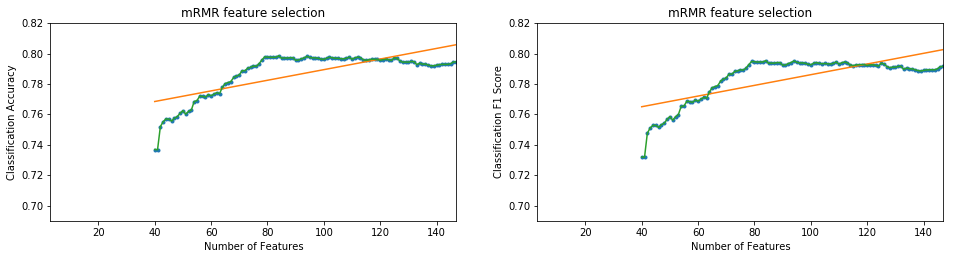

here


In [1]:
%matplotlib inline

import lsanomaly
import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA


# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('C:/Users/S/Documents/PY/increased100features.csv', low_memory=False)
'''data.loc[data['UUID'] == "RVTNB1502866560357", "attack"] = 1  
data.loc[data['UUID'] != "RVTNB1502866560357", "attack"] = -1
df_majority = data[data['attack']==-1]
df_minority = data[data['attack']==1]
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=830,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])

#print(data['attack'].value_counts())'''

#target=np.array(target)
#target = pd.DataFrame(target,columns=['attack'])

#data.drop(["UUID"], axis=1, inplace=True)
categorical_columns=["UUID"]
cate_data = data[categorical_columns]

#for col in data.columns.values:
#    print(col, data[col].unique())

pd.set_option('mode.chained_assignment', None)

def label_encode(cate_data, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(cate_data[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(cate_data[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        cate_data[col] = col_values_transformed
 
to_be_encoded_cols = cate_data.columns.values
label_encode(cate_data, to_be_encoded_cols)
display(cate_data.head())
target=cate_data['UUID']
target=np.array(target)
#target = pd.DataFrame(target)
#target=target1.values

data.drop(["UUID"], axis=1, inplace=True)
data=pd.concat([data,cate_data], axis=1)
data.drop(["UUID"], axis=1, inplace=True)
#display(scaled_data.head())


# check the shape for sanity checking.
data.shape
display(data.head())
print("initial data info",data.info())

from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

print("data is",data.shape)
from skfeature.function.information_theoretical_based import LCSI
from skfeature.function.information_theoretical_based import MRMR

from skfeature.utility.entropy_estimators import *
import scipy.io

from sklearn.preprocessing import StandardScaler
#scaled_data=data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaleddata= pd.DataFrame(scaled_data)
scaled_data=np.array(scaled_data)

print(scaled_data.shape)
print(target.shape)
#display(scaled_data.head())

#display(target.head())
#idx=MRMR.mrmr(scaled_data,target,n_selected_features=50)
'''from sklearn import cross_validation
ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
correct = 0
print("scaled data details - ",scaled_data.info())
print("target data details - ",target.info())
for train, test in ss:
    #print(scaled_data[train])
    #print(target[train])
        # obtain the index of each feature on the training set
    idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=50)

        # obtain the dataset on the selected features
    features = scaled_data[:, idx[0:50]]
print(features)    '''
'''skb= SVC(kernel="linear")
rfe = RFE(estimator=skb, n_features_to_select=70)
rfe=rfe.fit(scaleddata,target)
print(rfe.support_)
print(rfe.ranking_)
skft = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
for train, test in skft:
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model1 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model1.fit(X_train, Y_train)
    scores = cross_val_score(model1,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())'''
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=36851234)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
clf=SVC(kernel='linear')
#clf = svm.SVC(decision_function_shape='ovo')    # linear SVM
correct = 0
fscoreTotal =0
print(scaled_data.shape[1])
plt.figure(figsize=(16, 8))
accuracy = plt.subplot(221)

x=np.array([])
y=np.array([])
f1val=np.array([])
numoffeatures= lambda start, end: range(start, end+1)
for i in numoffeatures(40,scaled_data.shape[1]):
    for train, test in skf.split(scaled_data,target):
        # obtain the index of each feature on the training set
        idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=i)

        # obtain the dataset on the selected features
        features = scaled_data[:, idx[0:i]]
        #print(target[train])
        # train a classification model with the selected features on the training dataset
        clf.fit(features[train], target[train])

        # predict the class labels of test data
        y_predict = clf.predict(features[test])
        print("metrics")
        # obtain the classification accuracy on the test data
        acc = accuracy_score(target[test], y_predict)
        correct = correct + acc
        fscore=f1_score(target[test], y_predict,average='weighted')
        fscoreTotal=fscoreTotal+fscore
        #print("fsc ",f1_score(target[test], y_predict,average='weighted'))
        #print("conf mat ",confusion_matrix(target[test],y_predict))
        #print("ACCURACY: ", (accuracy_score(target[test], y_predict)))
        #report = classification_report(target[test], y_predict)
        #print(report)
    x=np.append(x,i)
    accscores=float(correct)/5
    f1scores=float(fscoreTotal)/5
    y=np.append(y,accscores)
    f1val=np.append(f1val,f1scores)
    print("loop ",i)
    print("f1 ",f1scores)
    # output the average classification accuracy over all 10 folds
    print("Accuracy:", accscores)
    fscore=0
    acc=0
    correct=0
    fscoreTotal=0
##svc=SelectKBest(mutual_info_classif, k=50).fit_transform(data,target)
#svc = SVC(kernel="linear")
#rfe = RFE(estimator=svc, n_features_to_select=10)
#rfe.fit(data, target)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
accuracy.plot(x,y)
accuracy.set_title("mRMR feature selection")
accuracy.set_xlim(3, scaled_data.shape[1])
accuracy.set_xlabel("Number of Features")
accuracy.set_ylim(0.69, 0.82)
accuracy.set_ylabel("Classification Accuracy")
f1=plt.subplot(222)
n, c = np.polyfit(x, f1val, 1)
plt.plot(x, f1val, '.')
plt.plot(x, n*x + c, '-')
f1.plot(x,f1val)
f1.set_title("mRMR feature selection")
f1.set_xlim(3, scaled_data.shape[1])
f1.set_xlabel("Number of Features")
f1.set_ylim(0.69, 0.82)
f1.set_ylabel("Classification F1 Score")
plt.show()
print("here")
#score = svc.score(data, target)
##print(svc)
#ranking = rfe.feature_importances_
#print("no of feat",ranking)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Columns: 155 entries, Num_of_CPU_Cores to Country_Code
dtypes: float64(148), int64(7)
memory usage: 932.5 KB
initial data info None
data is (770, 155)


,Num_of_CPU_Cores,pLN1,p.2,pLN3,pt4,pi5,pe6,pLN7,p58,pLN9,...,avdu2,avgp,avga,Language,Hardware_Model,SDK_Version,Manufacture,Screen_Size,Time_Zone,Country_Code
0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,88.200000,1.0,0.004412,0,40,3,18,23,7,1
1,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,95.400000,1.0,0.004167,0,40,3,18,23,7,1
2,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,575.333333,1.0,0.008333,0,40,3,18,23,7,1
3,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,466.400000,1.0,0.008211,0,40,3,18,23,7,1
4,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,121.800000,1.0,0.009804,0,40,3,18,23,7,1


(770, 155)
(770,)


,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,154
0,0.947994,0.815817,0.809086,0.798447,0.789706,0.797549,0.811362,0.818631,0.807158,0.798478,...,0.034875,0.98523,-0.757394,-0.114708,0.683891,0.171743,1.043473,0.656912,0.97342,-0.656639
1,0.947994,0.815817,0.809086,0.798447,0.789706,0.797549,0.811362,0.818631,0.807158,0.798478,...,0.034876,0.98523,-0.759460,-0.114708,0.683891,0.171743,1.043473,0.656912,0.97342,-0.656639
2,0.947994,0.815817,0.809086,0.798447,0.789706,0.797549,0.811362,0.818631,0.807158,0.798478,...,0.034911,0.98523,-0.724350,-0.114708,0.683891,0.171743,1.043473,0.656912,0.97342,-0.656639
3,0.947994,0.815817,0.809086,0.798447,0.789706,0.797549,0.811362,0.818631,0.807158,0.798478,...,0.034903,0.98523,-0.725382,-0.114708,0.683891,0.171743,1.043473,0.656912,0.97342,-0.656639
4,0.947994,0.815817,0.809086,0.798447,0.789706,0.797549,0.811362,0.818631,0.807158,0.798478,...,0.034877,0.98523,-0.711958,-0.114708,0.683891,0.171743,1.043473,0.656912,0.97342,-0.656639


[[ 0.9479941   0.81581729  0.80908589  0.79844709  0.78970645  0.79754904
   0.81136158  0.81863082  0.80715788  0.79847819  0.80098542  0.80111599
   0.78627805  0.78900207  0.800454    0.80686551  0.81359002 -0.5556951
  -0.52192503 -0.58472139 -0.56452003 -0.57079772 -0.53977777 -0.52882396
  -0.5396536  -0.51596472 -0.5223819  -0.53662663 -0.55084842 -0.58578593
  -0.69237416 -0.55338506 -0.54995248 -0.66373281 -0.5347144  -1.8664243 ]
 [ 0.9479941   0.81581729  0.80908589  0.79844709  0.78970645  0.79754904
   0.81136158  0.81863082  0.80715788  0.79847819  0.80098542  0.80111599
   0.78627805  0.78900207  0.800454    0.80686551  0.81359002 -0.57233581
  -0.63981923 -0.58472139 -0.56452003 -0.57079772 -0.53977777 -0.52882396
  -0.5396536  -0.51596472 -0.5223819  -0.53662663 -0.55084842 -0.58578593
  -0.54537671 -0.57000086 -0.56671929 -0.74549859 -1.89241756 -2.10619292]
 [ 0.9479941   0.81581729  0.80908589  0.79844709  0.78970645  0.79754904
   0.81136158  0.81863082  0.80715788

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_learning_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_learning_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


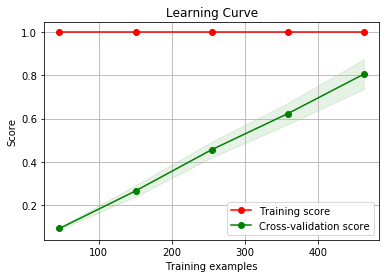

[[-0.5347144   0.9479941   0.68389052 -2.28563587  0.65691215 -0.66373281
   1.04347291 -0.51596472 -0.75739422  6.38502544 -0.12470872 -0.5556951
  -0.12023608 -0.65663945 -1.49382632 -0.28227709 -0.07662112 -0.16656294
   0.17174346 -0.49293601 -0.28227709 -0.12744617 -0.54995248  6.83991134
  -1.91164376  0.97341997 -1.8664243  -2.08892881 -0.28224449 -0.5396536
  -0.54413338 -0.55338506 -3.81549574  6.05545301 -3.38442288 -0.5223819 ]
 [-1.89241756  0.9479941   0.68389052 -1.48008264  0.65691215 -0.74549859
   1.04347291 -0.51596472 -0.75945951  6.38502544 -3.84720872 -0.57233581
  -0.12023612 -0.65663945 -0.57189145 -0.28227709 -4.28065261 -3.42066767
   0.17174346 -0.89267956 -0.28227709 -3.67651175 -0.56671929  6.83991134
  -2.10154235  0.97341997 -2.10619292 -2.16609836 -0.28224449 -0.5396536
  -0.62704399 -0.57000086 -0.0857449   6.05545301 -0.13227719 -0.5223819 ]
 [-0.5347144   0.9479941   0.68389052 -0.59827534  0.65691215 -0.66373281
   1.04347291 -0.51596472 -0.72434963  

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.534714,0.947994,0.683891,-2.285636,0.656912,-0.663733,1.043473,-0.515965,-0.757394,6.385025,...,-1.866424,-2.088929,-0.282244,-0.539654,-0.544133,-0.553385,-3.815496,6.055453,-3.384423,-0.522382
1,-1.892418,0.947994,0.683891,-1.480083,0.656912,-0.745499,1.043473,-0.515965,-0.759460,6.385025,...,-2.106193,-2.166098,-0.282244,-0.539654,-0.627044,-0.570001,-0.085745,6.055453,-0.132277,-0.522382
2,-0.534714,0.947994,0.683891,-0.598275,0.656912,-0.663733,1.043473,-0.515965,-0.724350,6.385025,...,-0.764598,-0.424353,-0.282244,-0.539654,-0.551044,-0.536769,-0.085744,6.055453,-0.132276,-0.522382
3,-0.829416,0.947994,0.683891,-0.897693,0.656912,-0.745499,1.043473,-0.515965,-0.725382,6.385025,...,-1.888561,-0.508749,-0.282244,-0.539654,-0.626066,-0.570001,-3.815169,6.055453,-3.384138,-0.522382
4,-0.534714,0.947994,0.683891,-2.285636,0.656912,-0.663733,1.043473,-0.515965,-0.711958,6.385025,...,-0.764598,-2.088929,-0.282244,-0.539654,-0.544133,-0.553385,-0.085744,6.055453,-0.132276,-0.522382


metrics


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[-0.66373281  0.9479941   0.68389052 -0.75739422  0.65691215  1.04347291
  -2.04052325  6.38502544 -0.5347144  -0.5556951  -2.28563587 -0.65663945
  -0.12470872 -0.28227709 -0.07662112 -0.51596472 -0.49293601  0.17174346
  -0.16656294  0.97341997 -1.67730193 -0.55338506 -0.12744617 -0.28227709
  -0.54413338  6.83991134 -0.12023608 -0.54995248 -1.8664243  -0.28224449
  -1.49382632 -0.5223819  -3.81549574  6.05545301 -1.91164376 -0.5396536 ]
 [-0.74549859  0.9479941   0.68389052 -0.75945951  0.65691215  1.04347291
  -2.02937552  6.38502544 -1.89241756 -0.57233581 -1.48008264 -0.65663945
  -3.84720872 -0.28227709 -4.28065261 -0.51596472 -0.89267956  0.17174346
  -3.42066767  0.97341997 -1.98665585 -0.57000086 -3.67651175 -0.28227709
  -0.62704399  6.83991134 -0.12023612 -0.56671929 -2.10619292 -0.28224449
  -0.57189145 -0.5223819  -0.0857449   6.05545301 -2.10154235 -0.5396536 ]
 [-0.66373281  0.9479941   0.68389052 -0.72434963  0.65691215  1.04347291
  -2.30016682  6.38502544 -0.5347144

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.663733,0.947994,0.683891,-0.757394,0.656912,1.043473,-2.040523,6.385025,-0.534714,-0.555695,...,-0.120236,-0.549952,-1.866424,-0.282244,-1.493826,-0.522382,-3.815496,6.055453,-1.911644,-0.539654
1,-0.745499,0.947994,0.683891,-0.759460,0.656912,1.043473,-2.029376,6.385025,-1.892418,-0.572336,...,-0.120236,-0.566719,-2.106193,-0.282244,-0.571891,-0.522382,-0.085745,6.055453,-2.101542,-0.539654
2,-0.663733,0.947994,0.683891,-0.724350,0.656912,1.043473,-2.300167,6.385025,-0.534714,-0.555695,...,-0.120236,-0.583486,-0.764598,-0.282244,-0.938997,-0.522382,-0.085744,6.055453,-1.424261,-0.539654
3,-0.745499,0.947994,0.683891,-0.725382,0.656912,1.043473,-1.527733,6.385025,-0.829416,-0.572336,...,-0.120236,-0.583486,-1.888561,-0.282244,-0.578715,-0.522382,-3.815169,6.055453,-0.522694,-0.539654
4,-0.663733,0.947994,0.683891,-0.711958,0.656912,1.043473,-2.040523,6.385025,-0.534714,-0.555695,...,-0.120236,-0.549952,-0.764598,-0.282244,-1.493826,-0.522382,-0.085744,6.055453,-1.911644,-0.539654


metrics
[[-0.5347144   0.9479941   0.68389052  0.65691215 -0.75739422 -0.66373281
   1.04347291 -2.28563587  6.38502544 -0.5556951  -1.49382632 -0.65663945
  -0.12470872 -0.28227709 -0.07662112 -0.51596472  0.17174346 -2.08892881
  -0.16656294  0.97341997 -0.49293601 -0.28227709 -0.12744617 -0.54995248
  -0.12023608 -0.55338506  6.05545301 -0.54413338 -0.28224449 -1.91164376
  -1.8664243   6.83991134  0.12430035 -0.5223819  -3.81549574 -0.52192503]
 [-1.89241756  0.9479941   0.68389052  0.65691215 -0.75945951 -0.74549859
   1.04347291 -1.48008264  6.38502544 -0.57233581 -0.57189145 -0.65663945
  -3.84720872 -0.28227709 -4.28065261 -0.51596472  0.17174346 -2.16609836
  -3.42066767  0.97341997 -0.89267956 -0.28227709 -3.67651175 -0.56671929
  -0.12023612 -0.57000086  6.05545301 -0.62704399 -0.28224449 -2.10154235
  -2.10619292  6.83991134  0.12429984 -0.5223819  -0.0857449  -0.63981923]
 [-0.5347144   0.9479941   0.68389052  0.65691215 -0.72434963 -0.66373281
   1.04347291 -0.59827534  6

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.534714,0.947994,0.683891,0.656912,-0.757394,-0.663733,1.043473,-2.285636,6.385025,-0.555695,...,6.055453,-0.544133,-0.282244,-1.911644,-1.866424,6.839911,0.124300,-0.522382,-3.815496,-0.521925
1,-1.892418,0.947994,0.683891,0.656912,-0.759460,-0.745499,1.043473,-1.480083,6.385025,-0.572336,...,6.055453,-0.627044,-0.282244,-2.101542,-2.106193,6.839911,0.124300,-0.522382,-0.085745,-0.639819
2,-0.534714,0.947994,0.683891,0.656912,-0.724350,-0.663733,1.043473,-0.598275,6.385025,-0.555695,...,6.055453,-0.551044,-0.282244,-1.424261,-0.764598,6.839911,0.124304,-0.522382,-0.085744,-0.521925
3,-0.829416,0.947994,0.683891,0.656912,-0.725382,-0.745499,1.043473,-0.897693,6.385025,-0.572336,...,6.055453,-0.626066,-0.282244,-0.522694,-1.888561,6.839911,0.124299,-0.522382,-3.815169,-0.521925
4,-0.534714,0.947994,0.683891,0.656912,-0.711958,-0.663733,1.043473,-2.285636,6.385025,-0.555695,...,6.055453,-0.544133,-0.282244,-1.911644,-0.764598,6.839911,0.124300,-0.522382,-0.085744,-0.521925


metrics
[[-0.5347144   0.9479941   0.68389052  0.65691215 -2.28563587  1.04347291
  -0.66373281  6.38502544 -0.75739422 -0.5556951  -1.49382632 -0.65663945
  -0.12470872 -0.28227709 -2.08892881  0.17174346 -0.07662112 -0.51596472
  -0.16656294  0.97341997 -0.49293601 -0.28227709 -0.12744617 -0.55338506
  -0.12023608 -0.28224449  0.11876718 -0.54995248 -0.54413338  6.83991134
  -1.8664243  -0.5223819   6.05545301 -1.91164376 -3.81549574  0.12430035]
 [-1.89241756  0.9479941   0.68389052  0.65691215 -1.48008264  1.04347291
  -0.74549859  6.38502544 -0.75945951 -0.57233581 -0.57189145 -0.65663945
  -3.84720872 -0.28227709 -2.16609836  0.17174346 -4.28065261 -0.51596472
  -3.42066767  0.97341997 -0.89267956 -0.28227709 -3.67651175 -0.57000086
  -0.12023612 -0.28224449  0.11876993 -0.56671929 -0.62704399  6.83991134
  -2.10619292 -0.5223819   6.05545301 -2.10154235 -0.0857449   0.12429984]
 [-0.5347144   0.9479941   0.68389052  0.65691215 -0.59827534  1.04347291
  -0.66373281  6.38502544 -0

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.534714,0.947994,0.683891,0.656912,-2.285636,1.043473,-0.663733,6.385025,-0.757394,-0.555695,...,0.118767,-0.549952,-0.544133,6.839911,-1.866424,-0.522382,6.055453,-1.911644,-3.815496,0.124300
1,-1.892418,0.947994,0.683891,0.656912,-1.480083,1.043473,-0.745499,6.385025,-0.759460,-0.572336,...,0.118770,-0.566719,-0.627044,6.839911,-2.106193,-0.522382,6.055453,-2.101542,-0.085745,0.124300
2,-0.534714,0.947994,0.683891,0.656912,-0.598275,1.043473,-0.663733,6.385025,-0.724350,-0.555695,...,4.258681,-0.583486,-0.551044,6.839911,-0.764598,-0.522382,6.055453,-1.424261,-0.085744,0.124304
3,-0.829416,0.947994,0.683891,0.656912,-0.897693,1.043473,-0.745499,6.385025,-0.725382,-0.572336,...,0.118772,-0.583486,-0.626066,6.839911,-1.888561,-0.522382,6.055453,-0.522694,-3.815169,0.124299
4,-0.534714,0.947994,0.683891,0.656912,-2.285636,1.043473,-0.663733,6.385025,-0.711958,-0.555695,...,0.118767,-0.549952,-0.544133,6.839911,-0.764598,-0.522382,6.055453,-1.911644,-0.085744,0.124300


metrics
[[-0.66373281  0.9479941   0.68389052 -0.75739422  0.65691215 -0.5347144
   1.04347291 -2.28563587  6.38502544 -0.12470872 -0.5556951  -0.65663945
  -0.16656294 -0.28227709 -1.49382632 -0.07662112  0.17174346 -0.51596472
  -0.12744617 -0.54995248 -0.12023608 -0.28227709 -0.49293601  0.97341997
  -1.8664243  -0.55338506 -2.08892881  6.05545301 -3.81549574 -0.28224449
  -3.38442288  0.12430035  6.83991134 -0.54413338 -0.52192503 -0.5223819 ]
 [-0.74549859  0.9479941   0.68389052 -0.75945951  0.65691215 -1.89241756
   1.04347291 -1.48008264  6.38502544 -3.84720872 -0.57233581 -0.65663945
  -3.42066767 -0.28227709 -0.57189145 -4.28065261  0.17174346 -0.51596472
  -3.67651175 -0.56671929 -0.12023612 -0.28227709 -0.89267956  0.97341997
  -2.10619292 -0.57000086 -2.16609836  6.05545301 -0.0857449  -0.28224449
  -0.13227719  0.12429984  6.83991134 -0.62704399 -0.63981923 -0.5223819 ]
 [-0.66373281  0.9479941   0.68389052 -0.72434963  0.65691215 -0.5347144
   1.04347291 -0.59827534  6.3

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.663733,0.947994,0.683891,-0.757394,0.656912,-0.534714,1.043473,-2.285636,6.385025,-0.124709,...,-2.088929,6.055453,-3.815496,-0.282244,-3.384423,0.124300,6.839911,-0.544133,-0.521925,-0.522382
1,-0.745499,0.947994,0.683891,-0.759460,0.656912,-1.892418,1.043473,-1.480083,6.385025,-3.847209,...,-2.166098,6.055453,-0.085745,-0.282244,-0.132277,0.124300,6.839911,-0.627044,-0.639819,-0.522382
2,-0.663733,0.947994,0.683891,-0.724350,0.656912,-0.534714,1.043473,-0.598275,6.385025,-0.124709,...,-0.424353,6.055453,-0.085744,-0.282244,-0.132276,0.124304,6.839911,-0.551044,-0.521925,-0.522382
3,-0.745499,0.947994,0.683891,-0.725382,0.656912,-0.829416,1.043473,-0.897693,6.385025,-0.124712,...,-0.508749,6.055453,-3.815169,-0.282244,-3.384138,0.124299,6.839911,-0.626066,-0.521925,-0.522382
4,-0.663733,0.947994,0.683891,-0.711958,0.656912,-0.534714,1.043473,-2.285636,6.385025,-0.124709,...,-2.088929,6.055453,-0.085744,-0.282244,-0.132276,0.124300,6.839911,-0.544133,-0.521925,-0.522382


metrics
f1  0.9699567099567099
Accuracy: 0.9727272727272727
here


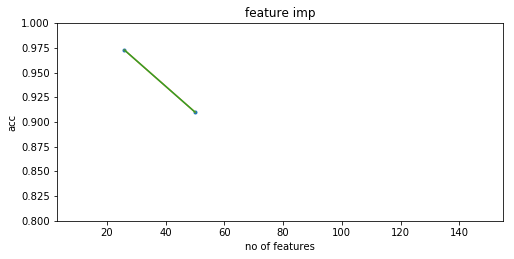

In [5]:
%matplotlib inline

import lsanomaly
import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA


# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('C:/Users/user/.spyder-py3/features1.csv', low_memory=False)
'''data.loc[data['UUID'] == "RVTNB1502866560357", "attack"] = 1  
data.loc[data['UUID'] != "RVTNB1502866560357", "attack"] = -1
df_majority = data[data['attack']==-1]
df_minority = data[data['attack']==1]
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=830,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])

#print(data['attack'].value_counts())'''

#target=np.array(target)
#target = pd.DataFrame(target,columns=['attack'])

#data.drop(["UUID"], axis=1, inplace=True)
categorical_columns=["UUID","Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"]
cate_data = data[categorical_columns]

#for col in data.columns.values:
#    print(col, data[col].unique())

pd.set_option('mode.chained_assignment', None)

def label_encode(cate_data, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(cate_data[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(cate_data[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        cate_data[col] = col_values_transformed
 
to_be_encoded_cols = cate_data.columns.values
label_encode(cate_data, to_be_encoded_cols)
#display(cate_data.head())
target=cate_data['UUID']
target=np.array(target)
#target = pd.DataFrame(target)
#target=target1.values

data.drop(["UUID","Language","Hardware_Model","SDK_Version","Manufacture","Screen_Size","Time_Zone","Country_Code"], axis=1, inplace=True)
data=pd.concat([data,cate_data], axis=1)
data.drop(["UUID"], axis=1, inplace=True)
#display(scaled_data.head())


# check the shape for sanity checking.
data.shape
#display(data.head())
print("initial data info",data.info())

from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

print("data is",data.shape)
from skfeature.function.information_theoretical_based import LCSI
from skfeature.function.information_theoretical_based import MRMR

from skfeature.utility.entropy_estimators import *

from sklearn.preprocessing import StandardScaler
#scaled_data=data
display(data.head())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaleddata= pd.DataFrame(scaled_data)
scaled_data=np.array(scaled_data)

print(scaled_data.shape)
print(target.shape)
display(scaleddata.head())
writer = pd.ExcelWriter('scaledfea1.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
scaleddata.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
print(scaled_data[:5,:36])
#display(target.head())
#idx=MRMR.mrmr(scaled_data,target,n_selected_features=50)
'''from sklearn import cross_validation
ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
correct = 0
print("scaled data details - ",scaled_data.info())
print("target data details - ",target.info())
for train, test in ss:
    #print(scaled_data[train])
    #print(target[train])
        # obtain the index of each feature on the training set
    idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=50)

        # obtain the dataset on the selected features
    features = scaled_data[:, idx[0:50]]
print(features)    '''
'''skb= SVC(kernel="linear")
rfe = RFE(estimator=skb, n_features_to_select=70)
rfe=rfe.fit(scaleddata,target)
print(rfe.support_)
print(rfe.ranking_)
skft = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
for train, test in skft:
    X_train,X_test=scaled_data.iloc[train],scaled_data.iloc[test]
    Y_train,y_test=target.iloc[train],target.iloc[test]
    model1 = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.10000000000000001)  
    model1.fit(X_train, Y_train)
    scores = cross_val_score(model1,X_test,y_test, cv=5, scoring='accuracy')
    print(scores)
print(scores.mean())'''
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

ss = cross_validation.KFold(5, n_folds=5, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=36851234)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=36851234)
from sklearn.model_selection import GridSearchCV
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
#clf = svm.SVC(decision_function_shape='ovo',kernel='rbf')    # linear SVM
clf=SVC(kernel='linear',probability=True)
import scikitplot.plotters as skplt
skplt.plot_learning_curve(clf, scaled_data, target)
plt.show()
correct = 0
fscoreTotal =0
plt.figure(figsize=(8, 8))
accuracy = plt.subplot(211)
for train, test in skf.split(scaled_data,target):
        # obtain the index of each feature on the training set
    idx,_,_ = MRMR.mrmr(scaled_data[train], target[train], n_selected_features=36)

        # obtain the dataset on the selected features
    features = scaled_data[:, idx[0:36]]
    feat= pd.DataFrame(features)
    print(features[:5,:])
    display(feat.head())
        #print(target[train])
        # train a classification model with the selected features on the training dataset
    clf.fit(features[train], target[train])

        # predict the class labels of test data
    y_predict = clf.predict(features[test])
    print("metrics")
        # obtain the classification accuracy on the test data
    acc = accuracy_score(target[test], y_predict)
    correct = correct + acc
    fscore=f1_score(target[test], y_predict,average='weighted')
    fscoreTotal=fscoreTotal+fscore
score=float(correct)/5
x=np.asarray([26,50])
y=np.array([score,0.91])
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
accuracy.plot(x,y)
accuracy.set_title("feature imp")
accuracy.set_xlim(3, 155)
accuracy.set_xlabel("no of features")
accuracy.set_ylim(0.8, 1)
accuracy.set_ylabel("acc")
        #print("fsc ",f1_score(target[test], y_predict,average='weighted'))
        #print("conf mat ",confusion_matrix(target[test],y_predict))
        #print("ACCURACY: ", (accuracy_score(target[test], y_predict)))
        #report = classification_report(target[test], y_predict)
        #print(report)
#plt.tight_layout()
#plt.show()
print("f1 ",float(fscoreTotal)/5)
    # output the average classification accuracy over all 10 folds
print("Accuracy:", float(correct)/5)
##svc=SelectKBest(mutual_info_classif, k=50).fit_transform(data,target)
#svc = SVC(kernel="linear")
#rfe = RFE(estimator=svc, n_features_to_select=10)
#rfe.fit(data, target)'''
print("here")